# Cluster images

[ WARN:0@1148.024] global loadsave.cpp:268 findDecoder imread_('NML_Google_images/59.148.93.jpg'): can't open/read file: check file path/integrity
[ WARN:0@1148.362] global loadsave.cpp:268 findDecoder imread_('NML_Google_images/59.148.99.jpg'): can't open/read file: check file path/integrity


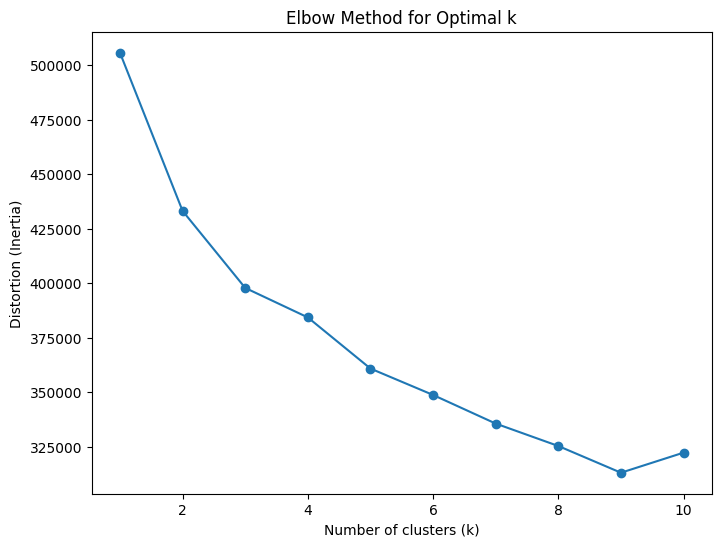

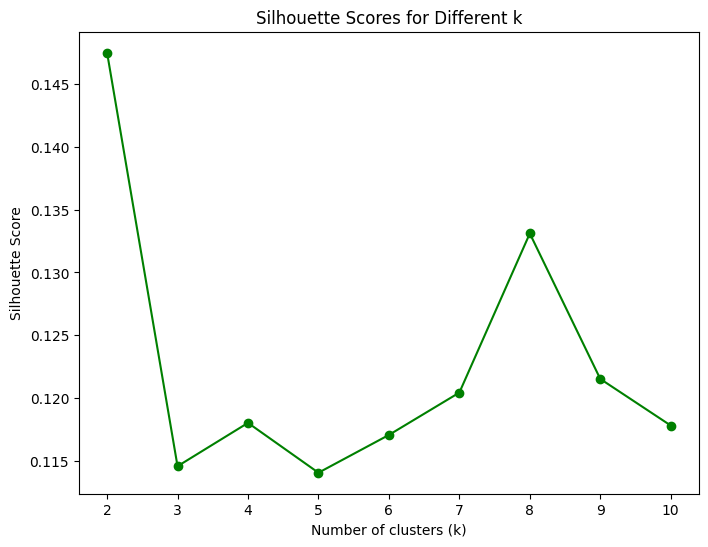

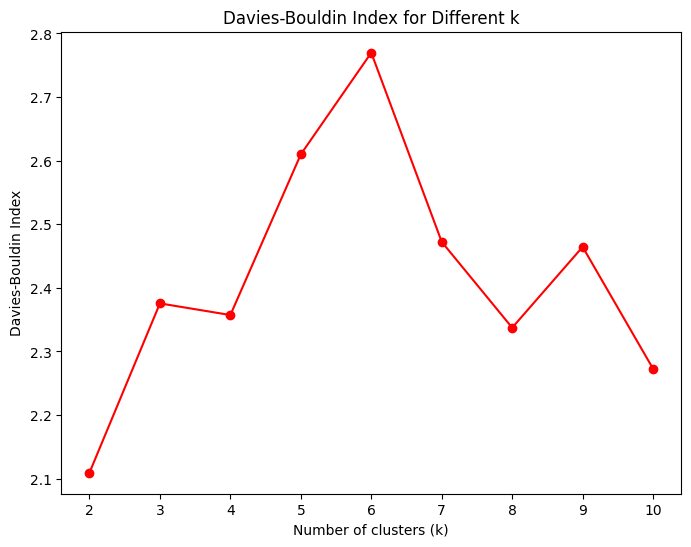

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import os
import cv2  # Ensure OpenCV is installed

# Load the CSV file
df = pd.read_csv('updated_with_alt_text_GPT_imagesFromHD4_Full2.csv', encoding='utf-8')

# Assuming your CSV has a column 'Extracted Image Path' that contains image paths
image_paths = df['Extracted Image Path'].dropna().tolist()  # Drop any NaN values

# Function to extract features from an image using a pre-trained model
def extract_image_features(image_path):
    try:
        img = cv2.imread(image_path)  # OpenCV for image loading
        img = cv2.resize(img, (224, 224))  # Resize image to match model input
        img_array = np.array(img, dtype=np.float32)  # Convert image to array
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
        features = model.predict(img_array, verbose=0)  # Suppress verbose output
        return features.flatten()  # Flatten features for clustering
    except Exception as e:
        return None  # Return None if there is an issue with the image

# Load the pre-trained model for feature extraction
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Extract features from all images
features = []
valid_image_paths = []
for path in image_paths:
    feature = extract_image_features(path)
    if feature is not None:  # Only append valid features
        features.append(feature)
        valid_image_paths.append(path)  # Keep track of valid image paths

# Check if features were extracted successfully
if len(features) == 0:
    print("No valid features extracted. Check your image paths.")
else:
    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=50)  # Reduce to 50 components
    reduced_features = pca.fit_transform(features)

    # Elbow Method (for determining optimal k)
     # Uses the Elbow Method to find the optimal number of clusters for K-Means.
     # Runs K-Means for K values ranging from 1 to 19.
     # Plots the distortion (inertia) for each value of K.
     # Helps determine the best K by identifying the point where inertia starts to decrease more slowly ("elbow point").
    
    distortions = []
    K_range = range(1, 11)  # Try different values of k (1 to 10)
    for k in K_range:
        kmeans = KMeans(n_clusters=k, verbose=0)  # Suppress verbose output
        kmeans.fit(reduced_features)
        distortions.append(kmeans.inertia_)

    # Plot Elbow Method
    plt.figure(figsize=(8, 6))
    plt.plot(K_range, distortions, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Distortion (Inertia)')
    plt.show()

    # Silhouette Score (for evaluating the clustering quality)
     # Computes the Silhouette Score, which measures how well-separated clusters are.
     # A higher score (closer to 1) indicates better-defined clusters.
    

    silhouette_scores = []
    for k in K_range[1:]:  # Start from 2 clusters (since silhouette score requires at least 2 clusters)
        kmeans = KMeans(n_clusters=k, verbose=0)  # Suppress verbose output
        kmeans.fit(reduced_features)
        score = silhouette_score(reduced_features, kmeans.labels_)
        silhouette_scores.append(score)

    # Plot Silhouette Scores
    plt.figure(figsize=(8, 6))
    plt.plot(K_range[1:], silhouette_scores, marker='o', color='g')
    plt.title('Silhouette Scores for Different k')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.show()

    # Davies-Bouldin Index (for evaluating how well-separated the clusters are)
     # Computes the Davies-Bouldin Index, which measures how similar clusters are.
     # A lower score is better (indicating well-separated clusters).

    davies_bouldin_scores = []
    for k in K_range[1:]:
        kmeans = KMeans(n_clusters=k, verbose=0)  # Suppress verbose output
        kmeans.fit(reduced_features)
        score = davies_bouldin_score(reduced_features, kmeans.labels_)
        davies_bouldin_scores.append(score)

    # Plot Davies-Bouldin Index Scores
    plt.figure(figsize=(8, 6))
    plt.plot(K_range[1:], davies_bouldin_scores, marker='o', color='r')
    plt.title('Davies-Bouldin Index for Different k')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Davies-Bouldin Index')
    plt.show()





# Take a decition for optimal number of clusters (k) based on the Elbow method, Davies-Bouldin Index, and Silhouette Score

In [ ]:
# Perform final KMeans clustering with optimal k (based on your chosen evaluation metric)
    optimal_k = 4  # For example, if k=3 seems optimal from your evaluation
    kmeans = KMeans(n_clusters=optimal_k, verbose=0)  # Suppress verbose output
    kmeans.fit(reduced_features)

    # Map images to clusters
    image_cluster_map = {valid_image_paths[i]: kmeans.labels_[i] for i in range(len(valid_image_paths))}

    # Optionally, save the mapping to a new CSV file
    df['Cluster'] = df['Extracted Image Path'].map(image_cluster_map)
    df.to_csv('clustered_images_with_metrics.csv', index=False)
    print("Clustering results saved to 'clustered_images_with_metrics.csv'.")

# Script to display clustered images

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageOps
from IPython.display import display
import IPython.display as ipd

# Load the CSV file
csv_path = "clustered_images_with_metrics.csv"
df = pd.read_csv(csv_path)

# Ensure correct column names
image_column = "Extracted Image Path"
cluster_column = "Cluster"

# Get unique non-empty clusters
non_empty_clusters = [cluster for cluster in df[cluster_column].unique() if df[df[cluster_column] == cluster][image_column].notna().sum() > 0]

# Relabel clusters sequentially (1-based)
cluster_mapping = {old_label: new_label + 1 for new_label, old_label in enumerate(sorted(non_empty_clusters))}
df["Relabeled Cluster"] = df[cluster_column].map(cluster_mapping)

# Define a dictionary of background colors for each cluster
cluster_colors = {
    1: (220, 200, 200),  # Light mint green for Cluster 1
    2: (255, 240, 200),  # Light yellow for Cluster 2
    3: (200, 220, 240),  # Light blue for Cluster 3
    4: (240, 220, 240),  # Light lavender for Cluster 4
    5: (240, 240, 200),  # Light cream for Cluster 5
    6: (200, 240, 220),  # Light aqua for Cluster 6
    7: (220, 240, 240),  # Soft turquoise for Cluster 7
    8: (240, 230, 200),  # Light beige for Cluster 8
    9: (220, 220, 240),  # Light periwinkle for Cluster 9
    # Add more clusters and colors as needed
}

# Function to pad images while keeping aspect ratio
def pad_image(img, size=256, bg_color=(220, 200, 200)):  # Default background color
    """Resizes an image to fit within a square while maintaining aspect ratio, padding with a background color."""
    img.thumbnail((size, size), Image.Resampling.LANCZOS)  # Resize while maintaining aspect ratio
    new_img = Image.new("RGB", (size, size), bg_color)  # Create a square canvas
    x_offset = (size - img.size[0]) // 2  # Center the image
    y_offset = (size - img.size[1]) // 2
    new_img.paste(img, (x_offset, y_offset))
    return new_img

# Function to save and display images for a given cluster
def save_and_display_images_for_cluster(cluster_df, cluster_label, output_dir="output_images"):
    images = cluster_df[image_column].dropna().tolist()[:9]  # Get first 9 images

    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Set the background color for the cluster
    bg_color = cluster_colors.get(int(cluster_label), (220, 200, 200))  # Default to mint green if not defined

    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    fig.suptitle(f"Cluster {int(cluster_label)}", fontsize=16)  # Force integer display

    for ax, img_path in zip(axes.flatten(), images):
        if os.path.exists(img_path):
            img = Image.open(img_path)
            img = pad_image(img, bg_color=bg_color)  # Use the cluster's background color
            ax.imshow(img)
            ax.set_title(os.path.basename(img_path), fontsize=8)
        else:
            ax.set_title("Not Found", fontsize=8)
        ax.axis("off")

    # Hide any empty subplots if <9 images
    for i in range(len(images), 9):
        axes.flatten()[i].axis("off")

    # Save the figure as a JPG file
    cluster_filename = os.path.join(output_dir, f"cluster_{int(cluster_label)}.jpg")
    plt.tight_layout()
    plt.savefig(cluster_filename, format="jpg", dpi=300)
    plt.show()  # Display the figure in the notebook

    # Print the saved file path and display the saved image
#    print(f"Saved cluster image: {cluster_filename}")
#    display(ipd.Image(cluster_filename))  # Display the saved image
    
# Loop through relabeled clusters (skipping the first one)
relabeled_clusters = sorted(df["Relabeled Cluster"].unique())

for relabeled_cluster in relabeled_clusters[1:]:  # Skip first cluster
    cluster_df = df[df["Relabeled Cluster"] == relabeled_cluster]
    save_and_display_images_for_cluster(cluster_df, relabeled_cluster)

